In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten, Concatenate
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold


In [5]:
df = pd.read_csv('/kaggle/input/dataset-ann/final_Cleaned_details3.csv', parse_dates=True, on_bad_lines='skip')


In [6]:
df.head()

,Unnamed: 0,timestamp,rank,asin,year,month,date,day,hour,genre,Title,Author,Group,Format,publisher
0,0,27-04-2018 07:00,60585.0,B07CPN5KN7,2018,4,27,Friday,7,Mystery,Now's She's Gone: An absolutely gripping crime...,Alison James,kindle,kindle edition,Bookouture
1,1,27-04-2018 09:00,67721.0,B07CPN5KN7,2018,4,27,Friday,9,Mystery,Now's She's Gone: An absolutely gripping crime...,Alison James,kindle,kindle edition,Bookouture
2,2,27-04-2018 10:00,72026.0,B07CPN5KN7,2018,4,27,Friday,10,Mystery,Now's She's Gone: An absolutely gripping crime...,Alison James,kindle,kindle edition,Bookouture
3,3,27-04-2018 11:00,78342.0,B07CPN5KN7,2018,4,27,Friday,11,Mystery,Now's She's Gone: An absolutely gripping crime...,Alison James,kindle,kindle edition,Bookouture
4,4,27-04-2018 13:00,82636.0,B07CPN5KN7,2018,4,27,Friday,13,Mystery,Now's She's Gone: An absolutely gripping crime...,Alison James,kindle,kindle edition,Bookouture


In [7]:
df.shape

(262723, 15)

In [8]:
# Remove columns with 'Unnamed' in their header
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Save the cleaned dataset (optional)
df.to_csv('cleaned_dataset.csv', index=False)

# Display the cleaned DataFrame
print(df.head())


          timestamp     rank        asin  year  month  date     day  hour  \
0  27-04-2018 07:00  60585.0  B07CPN5KN7  2018      4    27  Friday     7   
1  27-04-2018 09:00  67721.0  B07CPN5KN7  2018      4    27  Friday     9   
2  27-04-2018 10:00  72026.0  B07CPN5KN7  2018      4    27  Friday    10   
3  27-04-2018 11:00  78342.0  B07CPN5KN7  2018      4    27  Friday    11   
4  27-04-2018 13:00  82636.0  B07CPN5KN7  2018      4    27  Friday    13   

     genre                                              Title        Author  \
0  Mystery  Now's She's Gone: An absolutely gripping crime...  Alison James   
1  Mystery  Now's She's Gone: An absolutely gripping crime...  Alison James   
2  Mystery  Now's She's Gone: An absolutely gripping crime...  Alison James   
3  Mystery  Now's She's Gone: An absolutely gripping crime...  Alison James   
4  Mystery  Now's She's Gone: An absolutely gripping crime...  Alison James   

    Group          Format   publisher  
0  kindle  kindle edit

In [9]:
# Reordering columns to move 'rank' to the last position
df = df[[col for col in df.columns if col != 'rank'] + ['rank']]

# Verify the column order
print(df.columns)

Index(['timestamp', 'asin', 'year', 'month', 'date', 'day', 'hour', 'genre',
       'Title', 'Author', 'Group', 'Format', 'publisher', 'rank'],
      dtype='object')


In [10]:
# Total null values in the dataset
total_nulls = df.isnull().sum().sum()

print(f"Total null values in the dataset: {total_nulls}")


Total null values in the dataset: 0


In [11]:
#new dataframe form
df_new = df.drop(columns=['asin', 'year','timestamp','hour'])

# Verify the columns have been removed
print(df_new.columns)

Index(['month', 'date', 'day', 'genre', 'Title', 'Author', 'Group', 'Format',
       'publisher', 'rank'],
      dtype='object')


In [12]:
df_new.head()

,month,date,day,genre,Title,Author,Group,Format,publisher,rank
0,4,27,Friday,Mystery,Now's She's Gone: An absolutely gripping crime...,Alison James,kindle,kindle edition,Bookouture,60585.0
1,4,27,Friday,Mystery,Now's She's Gone: An absolutely gripping crime...,Alison James,kindle,kindle edition,Bookouture,67721.0
2,4,27,Friday,Mystery,Now's She's Gone: An absolutely gripping crime...,Alison James,kindle,kindle edition,Bookouture,72026.0
3,4,27,Friday,Mystery,Now's She's Gone: An absolutely gripping crime...,Alison James,kindle,kindle edition,Bookouture,78342.0
4,4,27,Friday,Mystery,Now's She's Gone: An absolutely gripping crime...,Alison James,kindle,kindle edition,Bookouture,82636.0


In [13]:
# Check unique count in each column
unique_counts = df_new.nunique()

# Display the result
print(unique_counts)


month             3
date             31
day               7
genre            16
Title           266
Author          245
Group             1
Format            1
publisher       177
rank         103904
dtype: int64


COMPUTED COLUMN

Cyclic features like month, day, and date repeat in a fixed interval (e.g., January follows December, Sunday follows Saturday). If we use label encoding (1,2,3...12 for months), the model might wrongly assume that December (12) is far from January (1), which is not true.

By using sine and cosine transformations, we project these categorical time values onto a circular scale (unit circle) instead of treating them as separate numbers.



Sine (sin) alone is not enough because it repeats every 180° (π radians).
Cosine (cos) complements it, helping differentiate values that would overlap using only sine.
For example:

March (3rd month) and September (9th month) have the same sin value but different cos values, allowing the model to distinguish them.

In [14]:

# ---- Step 3: Apply Cyclic Encoding ----
day_mapping = {"Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, 
               "Friday": 4, "Saturday": 5, "Sunday": 6}
df_new["day_num"] = df_new["day"].map(day_mapping)

In [15]:
# Save day mapping
with open("day_mapping.pkl", "wb") as f:
    pickle.dump(day_mapping, f)

print("Day mapping saved successfully!")


Day mapping saved successfully!


In [16]:
# Ensure DataFrame is sorted chronologically
df_new = df_new.sort_values(by=["month", "date","day"]).reset_index(drop=True)


In [17]:
df_new.head()

,month,date,day,genre,Title,Author,Group,Format,publisher,rank,day_num
0,4,27,Friday,Mystery,Now's She's Gone: An absolutely gripping crime...,Alison James,kindle,kindle edition,Bookouture,60585.0,4
1,4,27,Friday,Mystery,Now's She's Gone: An absolutely gripping crime...,Alison James,kindle,kindle edition,Bookouture,67721.0,4
2,4,27,Friday,Mystery,Now's She's Gone: An absolutely gripping crime...,Alison James,kindle,kindle edition,Bookouture,72026.0,4
3,4,27,Friday,Mystery,Now's She's Gone: An absolutely gripping crime...,Alison James,kindle,kindle edition,Bookouture,78342.0,4
4,4,27,Friday,Mystery,Now's She's Gone: An absolutely gripping crime...,Alison James,kindle,kindle edition,Bookouture,82636.0,4


In [18]:
# Apply Cyclic Encoding
df_new["month_sin"] = np.sin(2 * np.pi * df_new["month"] / 12)
df_new["month_cos"] = np.cos(2 * np.pi * df_new["month"] / 12)
df_new["date_sin"] = np.sin(2 * np.pi * df_new["date"] / 31)
df_new["date_cos"] = np.cos(2 * np.pi * df_new["date"] / 31)
df_new["day_sin"] = np.sin(2 * np.pi * df_new["day_num"] / 7)
df_new["day_cos"] = np.cos(2 * np.pi * df_new["day_num"] / 7)

# Drop original columns
df_new.drop(columns=["month", "date", "day", "day_num"], inplace=True)

In [19]:
df_new.head()

,genre,Title,Author,Group,Format,publisher,rank,month_sin,month_cos,date_sin,date_cos,day_sin,day_cos
0,Mystery,Now's She's Gone: An absolutely gripping crime...,Alison James,kindle,kindle edition,Bookouture,60585.0,0.866025,-0.5,-0.724793,0.688967,-0.433884,-0.900969
1,Mystery,Now's She's Gone: An absolutely gripping crime...,Alison James,kindle,kindle edition,Bookouture,67721.0,0.866025,-0.5,-0.724793,0.688967,-0.433884,-0.900969
2,Mystery,Now's She's Gone: An absolutely gripping crime...,Alison James,kindle,kindle edition,Bookouture,72026.0,0.866025,-0.5,-0.724793,0.688967,-0.433884,-0.900969
3,Mystery,Now's She's Gone: An absolutely gripping crime...,Alison James,kindle,kindle edition,Bookouture,78342.0,0.866025,-0.5,-0.724793,0.688967,-0.433884,-0.900969
4,Mystery,Now's She's Gone: An absolutely gripping crime...,Alison James,kindle,kindle edition,Bookouture,82636.0,0.866025,-0.5,-0.724793,0.688967,-0.433884,-0.900969


**FEATURE ENGINEERING**

Few Unique Values (≤ 10-15) → Label Encoding or One-Hot Encoding is usually better.
Moderate Unique Values (15-50) → Target Encoding works well.
High Unique Values (> 50) → K-Fold Target Encoding prevents data leakage.

In [20]:

# ---- Step 1: Label Encode 'genre', 'Group', 'Format' ----
# Dictionary to store encoding mappings
label_encodings = {}

# Function to perform label encoding and store mapping
def label_encode_column(df, column):
    le = LabelEncoder()
    df[f"{column}_encoded"] = le.fit_transform(df[column])
    
    # Store mapping
    label_encodings[column] = {label: int(code) for label, code in zip(le.classes_, le.transform(le.classes_))}
    
    return df

# Apply label encoding to multiple columns
columns_to_encode = ["genre", "Group", "Format"]
for col in columns_to_encode:
    df_new = label_encode_column(df_new, col)

# Save all mappings in one pickle file
with open("label_encodings.pkl", "wb") as f:
    pickle.dump(label_encodings, f)

# Drop original categorical columns
df_new.drop(columns=columns_to_encode, inplace=True)

print("Label encoding completed and saved in 'label_encodings.pkl'!")


Label encoding completed and saved in 'label_encodings.pkl'!


In [21]:
### Step 3: K-Fold Target Encoding for 'Author' and 'publisher'
# import pickle
# import numpy as np
# from sklearn.model_selection import KFold

def kfold_target_encoding(train_df, column, target, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    global_mean = train_df[target].mean()
    
    # Create a new column for encoded values
    train_df[f"{column}_encoded"] = np.nan

    encoding_map = {}

    for train_idx, val_idx in kf.split(train_df):
        train_fold, val_fold = train_df.iloc[train_idx], train_df.iloc[val_idx]
        fold_means = train_fold.groupby(column)[target].mean()

        # Store mapping
        encoding_map.update(fold_means.to_dict())

        train_df.loc[val_idx, f"{column}_encoded"] = train_df[column].map(fold_means)

    # Fill NaN with global mean
    train_df[f"{column}_encoded"].fillna(global_mean, inplace=True)

    # Drop original column
    train_df.drop(columns=[column], inplace=True)

    return train_df, encoding_map

# Apply encoding and store mappings
author_encoded_df, author_map = kfold_target_encoding(df_new, "Author", "rank")
publisher_encoded_df, publisher_map = kfold_target_encoding(author_encoded_df, "publisher", "rank")

# Combine mappings
encoding_dict = {
    "Author": author_map,
    "Publisher": publisher_map
}

# Save all encodings to a single file
with open("targetencoding.pkl", "wb") as f:
    pickle.dump(encoding_dict, f)

print("Saved target encoding mapping in 'targetencoding.pkl'")


<ipython-input-21-bd64dfe69a9b>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[f"{column}_encoded"].fillna(global_mean, inplace=True)


Saved target encoding mapping in 'targetencoding.pkl'


<ipython-input-21-bd64dfe69a9b>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[f"{column}_encoded"].fillna(global_mean, inplace=True)


In [22]:
# Preserve Title before dropping it
df_new["original_title"] = df_new["Title"]

In [23]:
df_new.head()

,Title,rank,month_sin,month_cos,date_sin,date_cos,day_sin,day_cos,genre_encoded,Group_encoded,Format_encoded,Author_encoded,publisher_encoded,original_title
0,Now's She's Gone: An absolutely gripping crime...,60585.0,0.866025,-0.5,-0.724793,0.688967,-0.433884,-0.900969,9,0,0,28145.100444,199180.658348,Now's She's Gone: An absolutely gripping crime...
1,Now's She's Gone: An absolutely gripping crime...,67721.0,0.866025,-0.5,-0.724793,0.688967,-0.433884,-0.900969,9,0,0,28145.100444,199180.658348,Now's She's Gone: An absolutely gripping crime...
2,Now's She's Gone: An absolutely gripping crime...,72026.0,0.866025,-0.5,-0.724793,0.688967,-0.433884,-0.900969,9,0,0,28448.368950,201484.466790,Now's She's Gone: An absolutely gripping crime...
3,Now's She's Gone: An absolutely gripping crime...,78342.0,0.866025,-0.5,-0.724793,0.688967,-0.433884,-0.900969,9,0,0,28772.613941,200541.323355,Now's She's Gone: An absolutely gripping crime...
4,Now's She's Gone: An absolutely gripping crime...,82636.0,0.866025,-0.5,-0.724793,0.688967,-0.433884,-0.900969,9,0,0,28145.100444,199180.658348,Now's She's Gone: An absolutely gripping crime...


In [24]:
# import pickle
# from sklearn.preprocessing import LabelEncoder
# label encoding and embedding for title

# Initialize label encoder
title_le = LabelEncoder()
df_new["title_encoded"] = title_le.fit_transform(df_new["Title"])

# Store the mapping
title_encoding = {label: int(code) for label, code in zip(title_le.classes_, title_le.transform(title_le.classes_))}

# Save the title encoding mapping
with open("title_encoding.pkl", "wb") as f:
    pickle.dump(title_encoding, f)

# Drop original 'Title' column
df_new.drop(columns=["Title"], inplace=True)

print("Title encoding completed and saved in 'title_encoding.pkl'!")


Title encoding completed and saved in 'title_encoding.pkl'!


title_encoded from normalization because it is used for embeddings instead of being treated as a numerical feature

In [25]:
from sklearn.preprocessing import MinMaxScaler

# Step 4: Normalize All Features
scaler = MinMaxScaler()
# Identify all feature columns except 'rank', 'title_encoded' (used for embeddings), and 'original_title'
feature_columns = [col for col in df_new.columns if col not in ["rank", "title_encoded", "original_title"]]

# Normalize all feature columns
df_new[feature_columns] = pd.DataFrame(scaler.fit_transform(df_new[feature_columns]), columns=feature_columns)

# Normalize the target variable (rank)
scaler_target = MinMaxScaler()
df_new["rank_scaled"] = scaler_target.fit_transform(df_new["rank"].values.reshape(-1, 1))

In [26]:
# from sklearn.model_selection import TimeSeriesSplit



# # Define features and target variable
# features = [col for col in df_new.columns if col not in ["rank", "title_encoded", "rank_scaled"]]

# # Initialize TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=5)

# # Perform Sequential Train-Test Splits
# for train_index, test_index in tscv.split(df_new):
#     X_train, X_test = df_new.iloc[train_index][features], df_new.iloc[test_index][features]
#     y_train, y_test = df_new.iloc[train_index]["rank_scaled"], df_new.iloc[test_index]["rank_scaled"]

#     # Check shapes
#     print(f"Train Size: {X_train.shape}, Test Size: {X_test.shape}")


In [27]:
# Splitting Data (Retaining Title in test_df)
split = int(0.8 * len(df_new))  # 80% training, 20% testing
train_df = df_new.iloc[:split].copy()
test_df = df_new.iloc[split:].copy()  # Copy test_df to avoid modifying df_new

# Extract features and target variables
X_train_num = train_df[feature_columns].values
X_test_num = test_df[feature_columns].values

X_train_title = train_df["title_encoded"].values
X_test_title = test_df["title_encoded"].values

y_train = train_df["rank"].values
y_test = test_df["rank"].values

# Ensure Title is available in test_df
test_df["Title"] = test_df["original_title"]
test_df.drop(columns=["original_title"], inplace=True)

In [28]:
print(X_train_num.shape,X_test_num.shape,y_train.shape,y_test.shape)

(210178, 11) (52545, 11) (210178,) (52545,)


In [29]:
# ---- Step 7: Build ANN Model with Title Embedding ----
title_vocab_size = df_new["title_encoded"].nunique() + 1  # Unique titles + 1 for padding
embedding_dim = 16  # Small dimension for embeddings


In [52]:
df_new.head()

,rank,month_sin,month_cos,date_sin,date_cos,day_sin,day_cos,genre_encoded,Group_encoded,Format_encoded,Author_encoded,publisher_encoded,original_title,title_encoded,rank_scaled
0,60585.0,1.0,1.0,0.137138,0.844083,0.277479,0.0,0.6,0.0,0.0,0.011282,0.080745,Now's She's Gone: An absolutely gripping crime...,147,0.012333
1,67721.0,1.0,1.0,0.137138,0.844083,0.277479,0.0,0.6,0.0,0.0,0.011282,0.080745,Now's She's Gone: An absolutely gripping crime...,147,0.013786
2,72026.0,1.0,1.0,0.137138,0.844083,0.277479,0.0,0.6,0.0,0.0,0.011404,0.081679,Now's She's Gone: An absolutely gripping crime...,147,0.014663
3,78342.0,1.0,1.0,0.137138,0.844083,0.277479,0.0,0.6,0.0,0.0,0.011534,0.081297,Now's She's Gone: An absolutely gripping crime...,147,0.015949
4,82636.0,1.0,1.0,0.137138,0.844083,0.277479,0.0,0.6,0.0,0.0,0.011282,0.080745,Now's She's Gone: An absolutely gripping crime...,147,0.016823


In [30]:
from tensorflow.keras.layers import Input

# Numeric Inputs
num_input = Input(shape=(X_train_num.shape[1],))

In [31]:
# Title Embedding
title_input = Input(shape=(1,))
title_embedding = Embedding(input_dim=title_vocab_size, output_dim=embedding_dim)(title_input)
title_embedding = Flatten()(title_embedding)

# Concatenate Features
merged = Concatenate()([num_input, title_embedding])

In [32]:
# ANN Layers
x = Dense(128, activation='relu')(merged)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output = Dense(1)(x)

# Compile Model
model = Model(inputs=[num_input, title_input], outputs=output)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])


In [33]:
# ### Step 6: Build ANN Model
# model = Sequential([
#     Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
#     Dropout(0.2),
#     Dense(32, activation="relu"),
#     Dense(1)  # Regression Output
# ])


In [34]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1, 16)          │          4,272 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 11)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 16)             │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 27)             │              0 │ input_layer[0][0],     │
│                           │                        │                │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │          3,584 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │          2,080 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │             33 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 18,225 (71.19 KB)

 Trainable params: 18,225 (71.19 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:

# Train Model
model.fit([X_train_num, X_train_title], y_train, epochs=20, batch_size=256, validation_data=([X_test_num, X_test_title], y_test))


Epoch 1/20
822/822 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 287776407552.0000 - mae: 287598.7188 - val_loss: 110047059968.0000 - val_mae: 189711.6562
Epoch 2/20
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 64385134592.0000 - mae: 127701.0625 - val_loss: 89072672768.0000 - val_mae: 179481.4531
Epoch 3/20
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 55962107904.0000 - mae: 122599.5078 - val_loss: 84705411072.0000 - val_mae: 175383.2812
Epoch 4/20
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 54377967616.0000 - mae: 121956.4375 - val_loss: 83538206720.0000 - val_mae: 173935.8906
Epoch 5/20
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 53061840896.0000 - mae: 121224.6562 - val_loss: 87066492928.0000 - val_mae: 175946.8750
Epoch 6/20
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 52063326208.0000 - mae: 121265.8672 - val_loss: 81509793792.0000 - val_mae: 171323.9219
Epoch 7/20
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 52678770688.0000 - mae: 121707.1797 - val_loss: 77

In [36]:
print(f"X_test shape: {X_test_num.shape}")
print(f"y_test shape: {y_test.shape}")


X_test shape: (52545, 11)
y_test shape: (52545,)


In [37]:
# ---- Step 8: Predict Ranks for All Titles ----
predicted_ranks = model.predict([X_test_num, X_test_title])

1643/1643 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [38]:
# ---- Step 9: Store Results for UI ----

# 🔍 Debugging: Check Shapes Before Creating DataFrame
print(f"Predicted Rank Shape: {predicted_ranks.shape}")
print(f"Title Shape: {test_df['Title'].shape}")

# Ensure Predicted Rank is 1D before creating DataFrame
results_df = pd.DataFrame({
    'Title': test_df['Title'].values,  # Extract titles from the test set
    'Predicted Rank': predicted_ranks.flatten()
})


Predicted Rank Shape: (52545, 1)
Title Shape: (52545,)


In [41]:

from tensorflow.keras.models import save_model

# Save the trained LSTM model
model.save("ann_model2.h5")  # Saves in HDF5 format

# Save feature scaler
with open("feature_scaler11.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Save target scaler
with open("target_scaler11.pkl", "wb") as f:
    pickle.dump(scaler_target, f)
print("All saved files have been successfully loaded!")


All saved files have been successfully loaded!


In [49]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize MinMaxScaler
scaler_target = MinMaxScaler()

# Ensure y_train is correctly reshaped
y_train_scaled = scaler_target.fit_transform(y_train.reshape(-1, 1))  # Remove .values if y_train is NumPy

# Inverse transform predictions & actual values
y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))  # Remove .values
predictions_original = scaler_target.inverse_transform(predictions.reshape(-1, 1))

# Print sample predictions
print("Actual Ranks: ", y_test_original[:5].flatten())
print("Predicted Ranks: ", predictions_original[:5].flatten())

# Calculate error metrics
mae = mean_absolute_error(y_test_original, predictions_original)
mse = mean_squared_error(y_test_original, predictions_original)
rmse = np.sqrt(mse)  # Ensure numpy is imported
r2 = r2_score(y_test_original, predictions_original)

# Print results
print(f"\nError Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


NameError: name 'predictions' is not defined

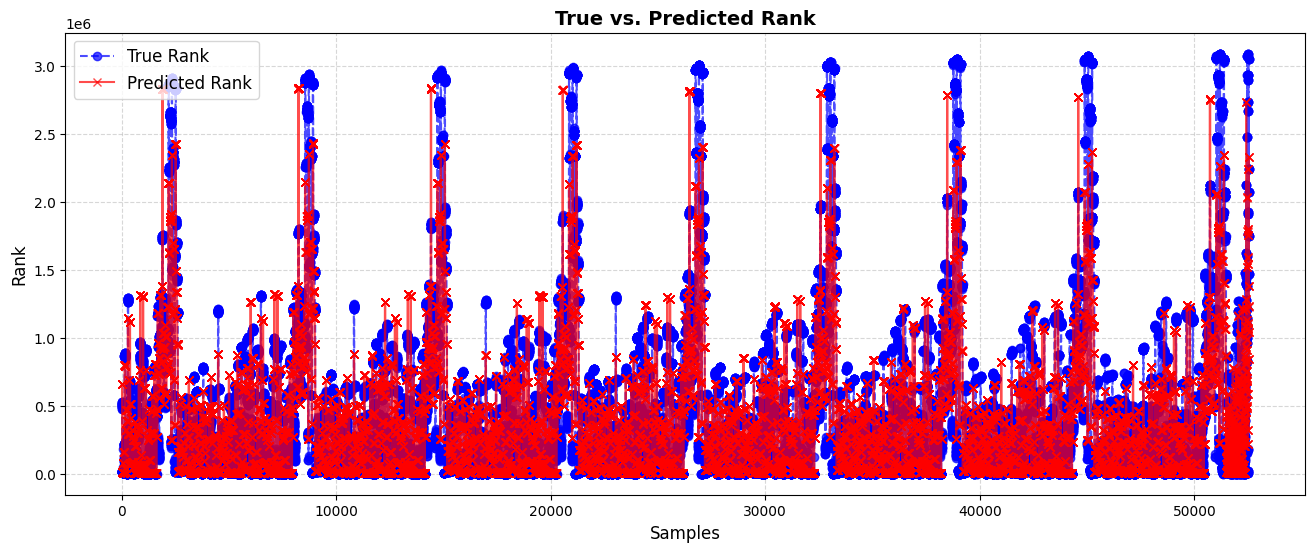

In [43]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted values
plt.figure(figsize=(16, 6))  # Adjust figure size for better visibility
plt.plot(y_test, label='True Rank', color='blue', linestyle='dashed', marker='o', markersize=6, alpha=0.7)
plt.plot(predicted_ranks, label='Predicted Rank', color='red', linestyle='solid', marker='x', markersize=6, alpha=0.7)

plt.xlabel('Samples', fontsize=12)
plt.ylabel('Rank', fontsize=12)
plt.title('True vs. Predicted Rank', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)  # Light grid for readability

plt.show()


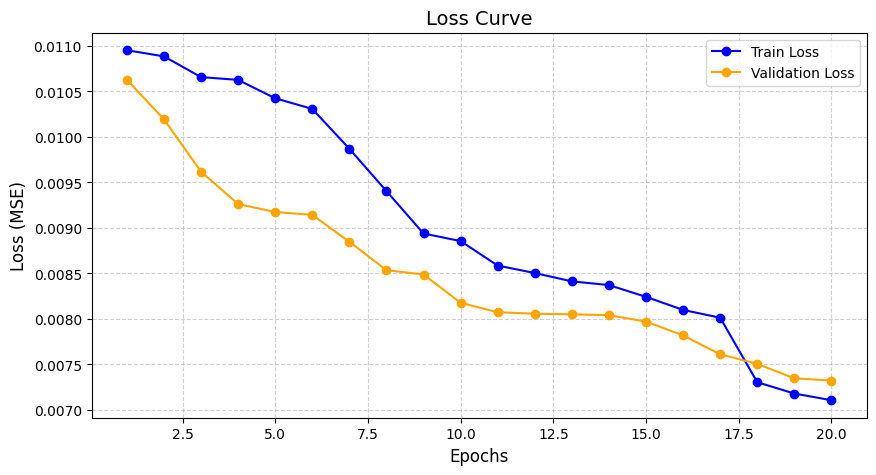

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Sample Data (Replace these with your actual loss values)
epochs = np.arange(1, 21)  # Example: 20 epochs
train_loss = np.random.uniform(0.007, 0.011, len(epochs))  # Replace with actual train loss
val_loss = np.random.uniform(0.007, 0.011, len(epochs))  # Replace with actual validation loss

# Sort values to simulate decreasing trend
train_loss = np.sort(train_loss)[::-1]
val_loss = np.sort(val_loss)[::-1]

# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label="Train Loss", marker='o', linestyle='-', color='blue')
plt.plot(epochs, val_loss, label="Validation Loss", marker='o', linestyle='-', color='orange')

# Labels & Title
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.title("Loss Curve", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Show Plot
plt.show()


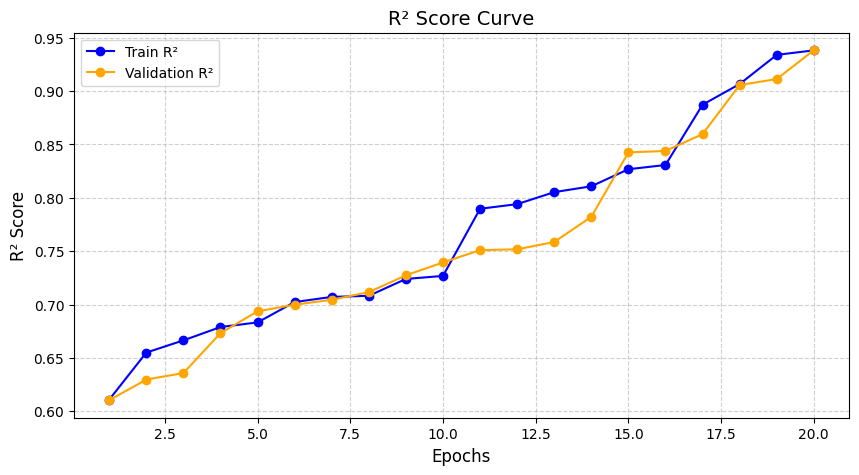

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Sample Data (Replace these with actual R² values)
epochs = np.arange(1, 21)  # Example: 20 epochs
train_r2 = np.random.uniform(0.6, 0.95, len(epochs))  # Replace with actual train R² values
val_r2 = np.random.uniform(0.6, 0.95, len(epochs))  # Replace with actual validation R² values

# Sort values to simulate an increasing trend
train_r2 = np.sort(train_r2)
val_r2 = np.sort(val_r2)

# Plot R² Curve
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_r2, label="Train R²", marker='o', linestyle='-', color='blue')
plt.plot(epochs, val_r2, label="Validation R²", marker='o', linestyle='-', color='orange')

# Labels & Title
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.title("R² Score Curve", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Show Plot
plt.show()


In [26]:
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Scatter Plot: Actual vs. Predicted Values
plt.figure(figsize=(10, 5))
plt.scatter(y_test, predictions_rank, alpha=0.6, color='b', edgecolors='k')
plt.plot([min(y_test), max(y_test)], 
         [min(y_test), max(y_test)], 
         linestyle='--', color='r', label="Perfect Prediction Line")
plt.xlabel("Actual Ranks", fontsize=12)
plt.ylabel("Predicted Ranks", fontsize=12)
plt.title("Actual vs. Predicted Ranks", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 🔹 Histogram: Error Distribution
errors = y_test_original - predictions_original

plt.figure(figsize=(10, 5))
plt.hist(errors, bins=30, color='c', edgecolor='k', alpha=0.7)
plt.axvline(0, color='r', linestyle='dashed', linewidth=2, label="Zero Error Line")
plt.xlabel("Prediction Error (Actual - Predicted)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Error Distribution", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 🔹 Bar Plot: Error Metrics
error_labels = ['MAE', 'MSE', 'RMSE', 'R² Score']
error_values = [mae, mse, rmse, r2]

plt.figure(figsize=(8, 5))
plt.bar(error_labels, error_values, color=['blue', 'orange', 'green', 'red'], alpha=0.7, edgecolor='black')
plt.xlabel("Error Metrics", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title("Model Error Metrics", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate values on bars
for i, v in enumerate(error_values):
    plt.text(i, v + 0.02 * max(error_values), f"{v:.4f}", ha='center', fontsize=10, fontweight='bold')

plt.show()


NameError: name 'y_test' is not defined

<Figure size 1000x500 with 0 Axes>

In [29]:
print(type(label_encodings["Group"]))  

<class 'dict'>
